In [32]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12          # Base font size
plt.rcParams['axes.titlesize'] = 18     # Axes title
plt.rcParams['axes.labelsize'] = 15     # X and Y labels
plt.rcParams['xtick.labelsize'] = 13    # X tick labels
plt.rcParams['ytick.labelsize'] = 13    # Y tick labels
plt.rcParams['legend.fontsize'] = 13    # Legend
plt.rcParams['figure.titlesize'] = 30   # Figure title (suptitle)

In [33]:
EEG_INDEX = 2
SPECTROGRAM_TYPE = "cwt"  # Options: "mel", "stft", "cwt"

TRAIN_CSV = Path(os.getcwd()).parent.parent / "data" / "train.csv"
EEG_DIR = Path(os.getcwd()).parent.parent / "data" / "train_eegs"
KAGGLE_SPECTROGRAM_DIR = Path(os.getcwd()).parent.parent / "data" / "train_spectrograms"
EEG_SPECTROGRAMS_DIR = Path(os.getcwd()).parent.parent / "data" / "processed" / "eeg_spectrograms" / "train" / SPECTROGRAM_TYPE

In [34]:
train_df = pd.read_csv(TRAIN_CSV)

row = train_df.iloc[EEG_INDEX]
eeg_id = row["eeg_id"]
spectrogram_id = row["spectrogram_id"]

eeg_parquet_path = EEG_DIR / f"{eeg_id}.parquet"
kaggle_spectrogram_path = KAGGLE_SPECTROGRAM_DIR / f"{spectrogram_id}.parquet"
eeg_spectrogram_path = EEG_SPECTROGRAMS_DIR / f"{eeg_id}.npy"

print(f"EEG ID: {eeg_id}")
print(f"Label: {row['expert_consensus']}")

EEG ID: 1628180742
Label: Seizure


In [35]:
print(row)

eeg_id                              1628180742
eeg_sub_id                                   2
eeg_label_offset_seconds                   8.0
spectrogram_id                          353733
spectrogram_sub_id                           2
spectrogram_label_offset_seconds           8.0
label_id                            1142670488
patient_id                               42516
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 2, dtype: object


In [36]:
eeg_offset = row["eeg_label_offset_seconds"]
eeg_parquet = pd.read_parquet(eeg_parquet_path)
eeg_parquet = eeg_parquet.drop(columns=["EKG"])
eeg_parquet = eeg_parquet.iloc[int(eeg_offset * 200) : int(eeg_offset * 200 + 200 * 50)] # select 50 seconds of data

kaggle_spectrogram_offset = row["spectrogram_label_offset_seconds"]
kaggle_spectrogram_content = pd.read_parquet(kaggle_spectrogram_path)
kaggle_spectrogram_content = kaggle_spectrogram_content.drop(columns=["time"])
kaggle_spectrogram_content = kaggle_spectrogram_content.iloc[int(kaggle_spectrogram_offset // 2) : int(kaggle_spectrogram_offset // 2 + 600 / 2)] # select 600 seconds of data

eeg_spectrogram_parquet = np.load(eeg_spectrogram_path)

In [37]:
print(f"EEG length: {eeg_parquet.shape[0] / 200} seconds")
print(f"Kaggle spectrogram length: {kaggle_spectrogram_content.shape[0] * 2} seconds")

EEG length: 50.0 seconds
Kaggle spectrogram length: 600 seconds


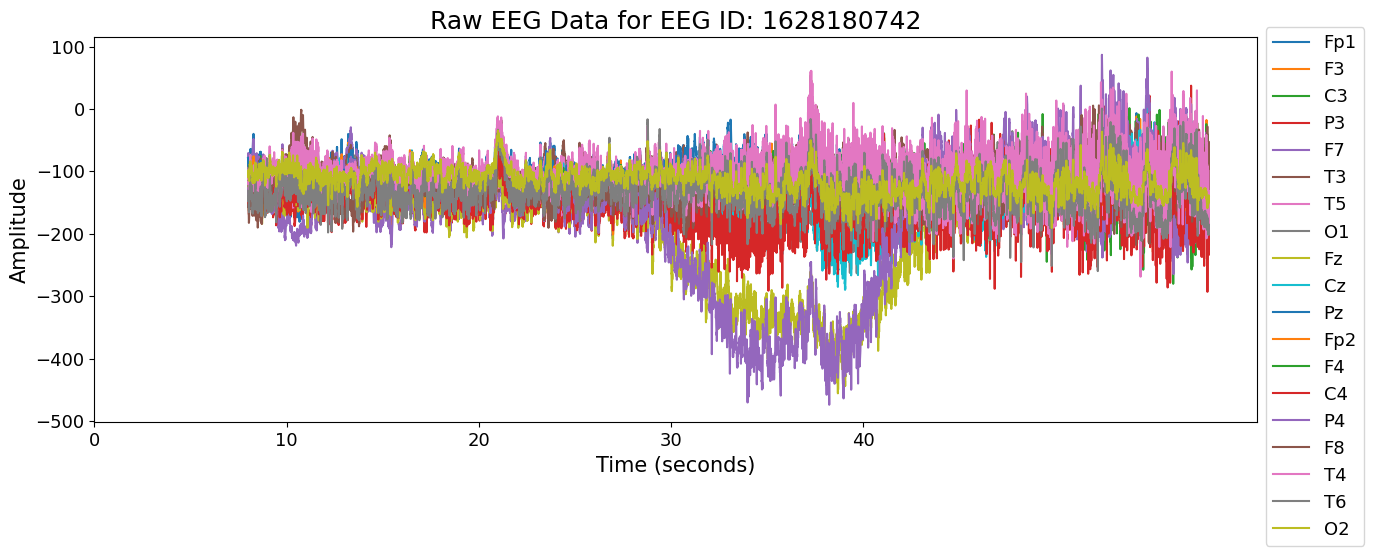

In [38]:
# visualize the raw EEG data in one line plot
# divide x-axis by 200 to convert from samples to seconds

fig, ax = plt.subplots(figsize=(15, 5))
for channel in eeg_parquet.columns:
    ax.plot(eeg_parquet[channel], label=channel)

ax.set_title(f"Raw EEG Data for EEG ID: {eeg_id}")
ax.set_xticks(ticks=np.arange(0, len(eeg_parquet), 2000), labels=np.arange(0, len(eeg_parquet) // 200, 10))
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Amplitude")
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.05));

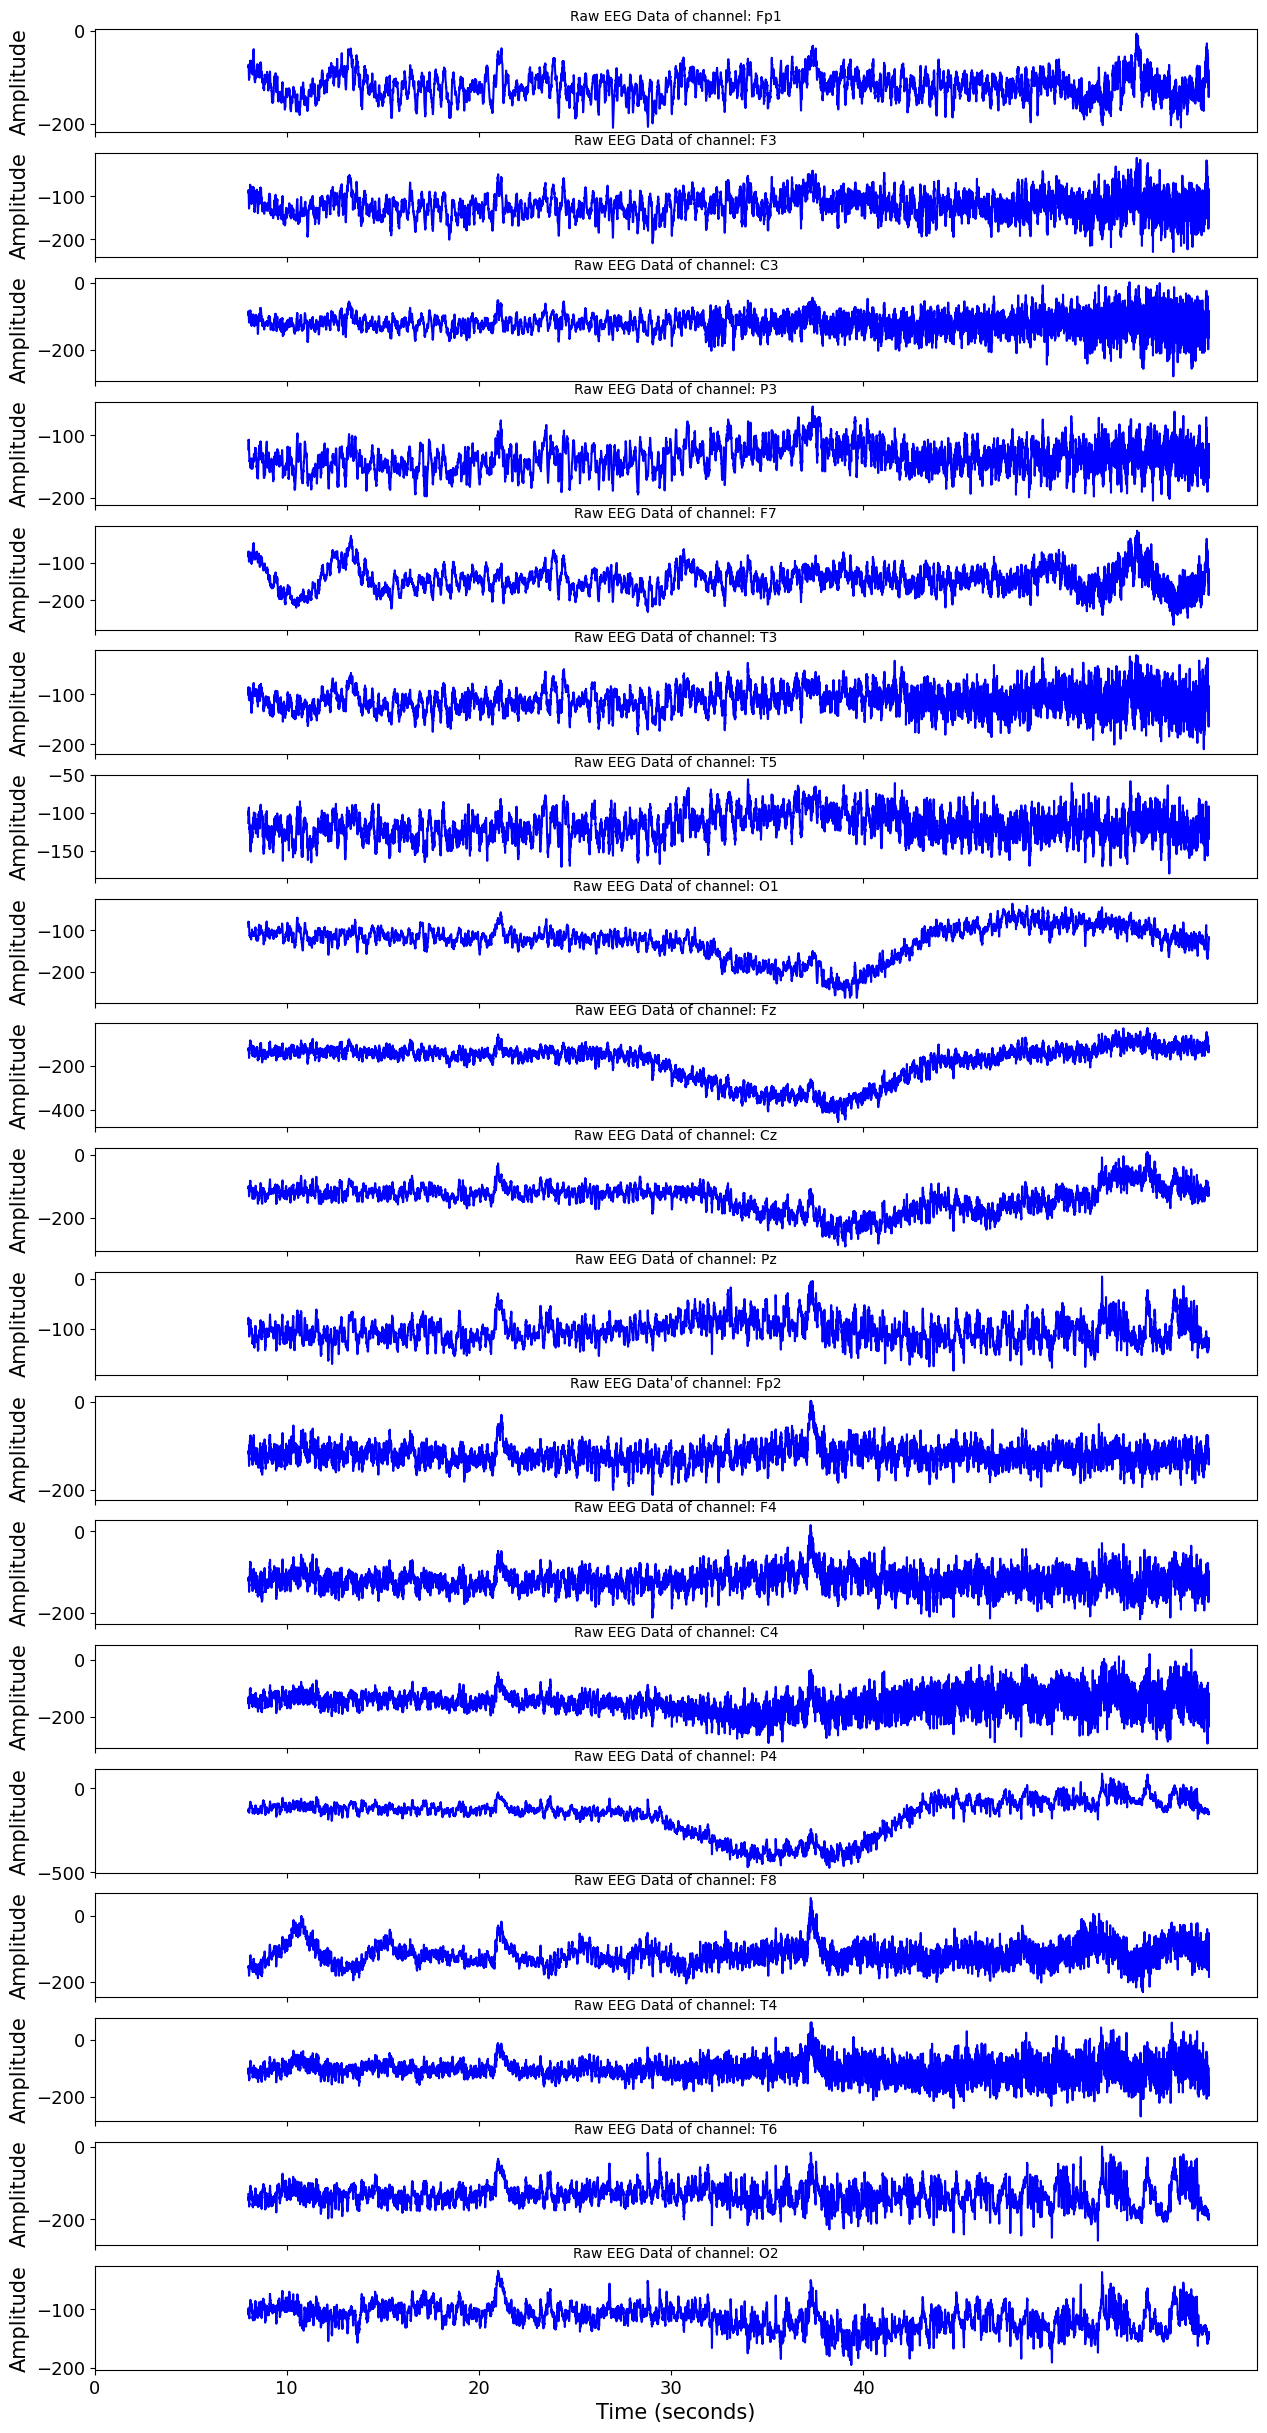

In [39]:
# visualize the raw EEG data in one line plot per channel
fig, axs = plt.subplots(nrows=len(eeg_parquet.columns), ncols=1, figsize=(15, 1.6 * len(eeg_parquet.columns)), sharex=True)
for i, channel in enumerate(eeg_parquet.columns):
    axs[i].plot(eeg_parquet[channel], label=channel, color='blue')
    axs[i].set_title(f"Raw EEG Data of channel: {channel}", fontsize=10)
    axs[i].set_ylabel("Amplitude")

axs[-1].set_xticks(ticks=np.arange(0, len(eeg_parquet), 2000), labels=np.arange(0, len(eeg_parquet) // 200, 10))
axs[-1].set_xlabel("Time (seconds)");

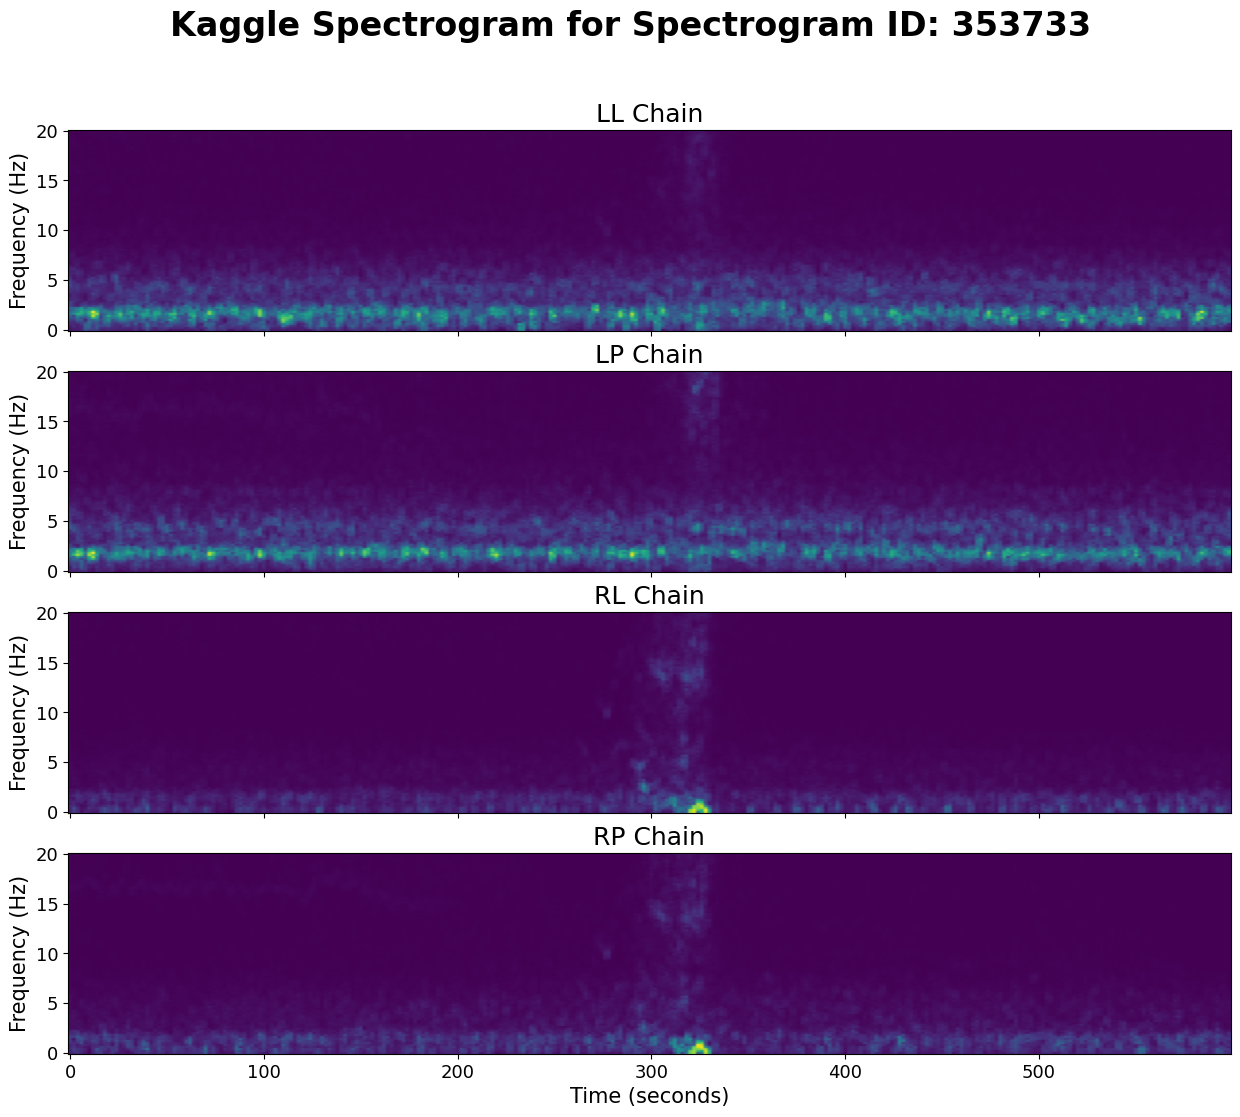

In [40]:
# visualize the Kaggle spectrogram
chain_names = ["LL", "LP", "RL", "RP"]

fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = kaggle_spectrogram_content.filter(like=chain).to_numpy().T
    axs[i].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 5), labels=np.linspace(0, 20, 5).astype(int))

axs[-1].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1], 50), labels=np.arange(0, spectrogram_data.shape[1] * 2, 100))
axs[-1].set_xlabel("Time (seconds)");

fig.suptitle(f"Kaggle Spectrogram for Spectrogram ID: {spectrogram_id}", fontsize=24, fontweight='bold');

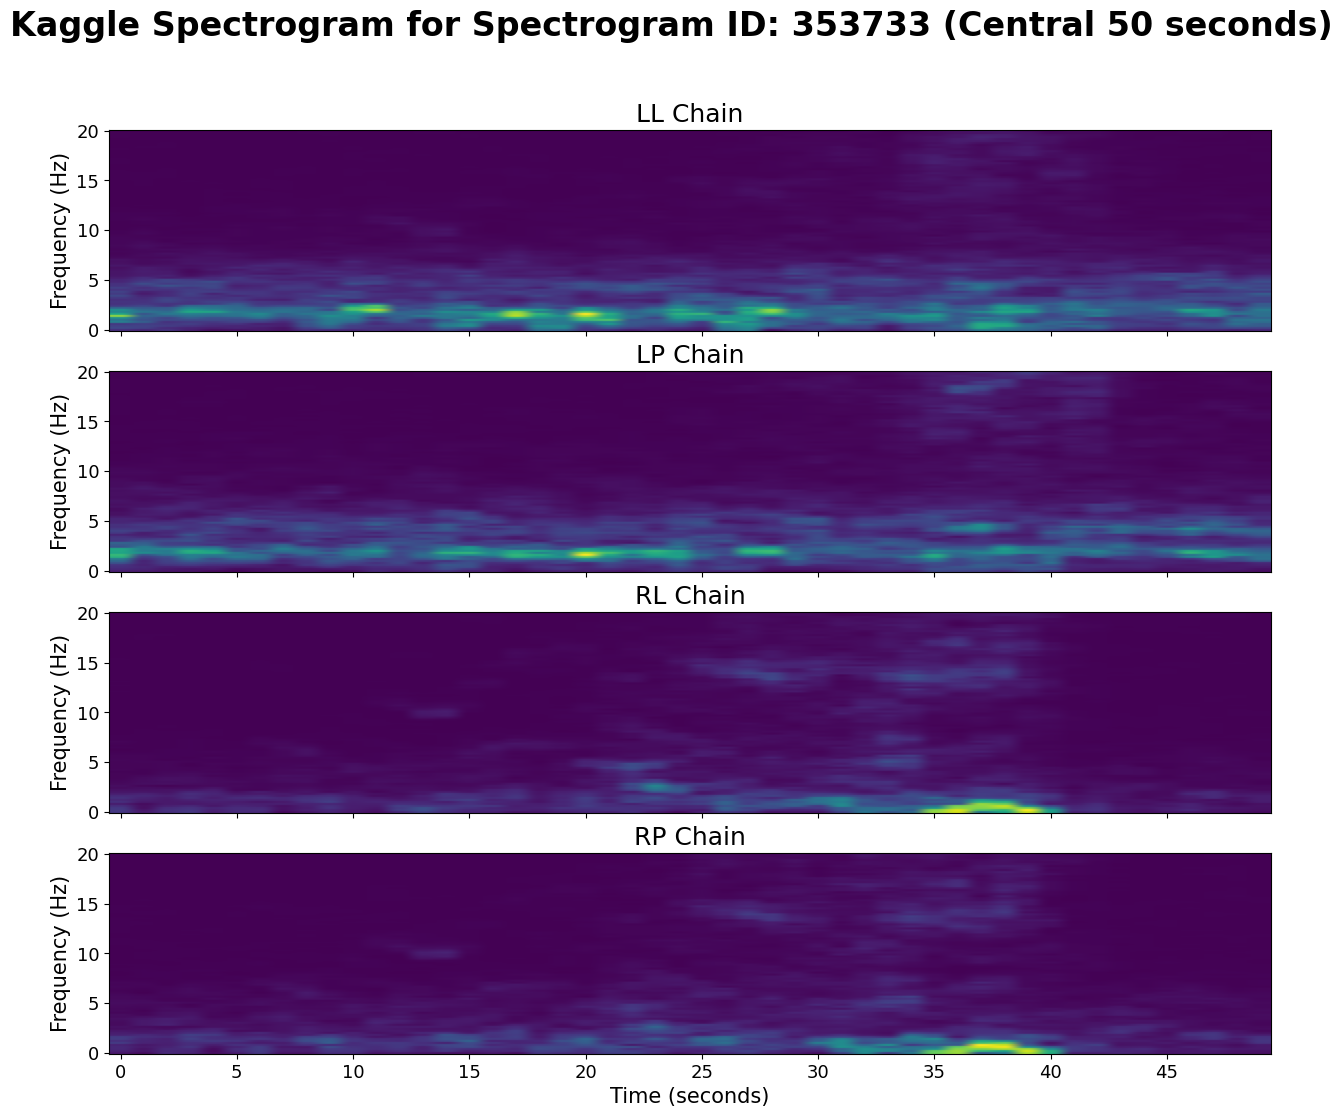

In [41]:
# visualize central 50 second of the Kaggle spectrogram
chain_names = ["LL", "LP", "RL", "RP"]
fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = kaggle_spectrogram_content.filter(like=chain).to_numpy().T
    center_start = spectrogram_data.shape[1] // 2 - 25
    center_end = spectrogram_data.shape[1] // 2 + 25
    axs[i].imshow(spectrogram_data[:, center_start:center_end], aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 5), labels=np.linspace(0, 20, 5).astype(int))

axs[-1].set_xticks(ticks=np.arange(0, 50, 5), labels=np.arange(0, 50, 5))
axs[-1].set_xlabel("Time (seconds)");
fig.suptitle(f"Kaggle Spectrogram for Spectrogram ID: {spectrogram_id} (Central 50 seconds)", fontsize=24, fontweight='bold');

min: -0.34276843070983887, max: 0.9089238047599792
min: -0.3903146982192993, max: 0.8549476265907288
min: -0.365411639213562, max: 0.9332599639892578
min: -0.4125966429710388, max: 0.9686462879180908
min: -0.6220259666442871, max: 0.906950831413269


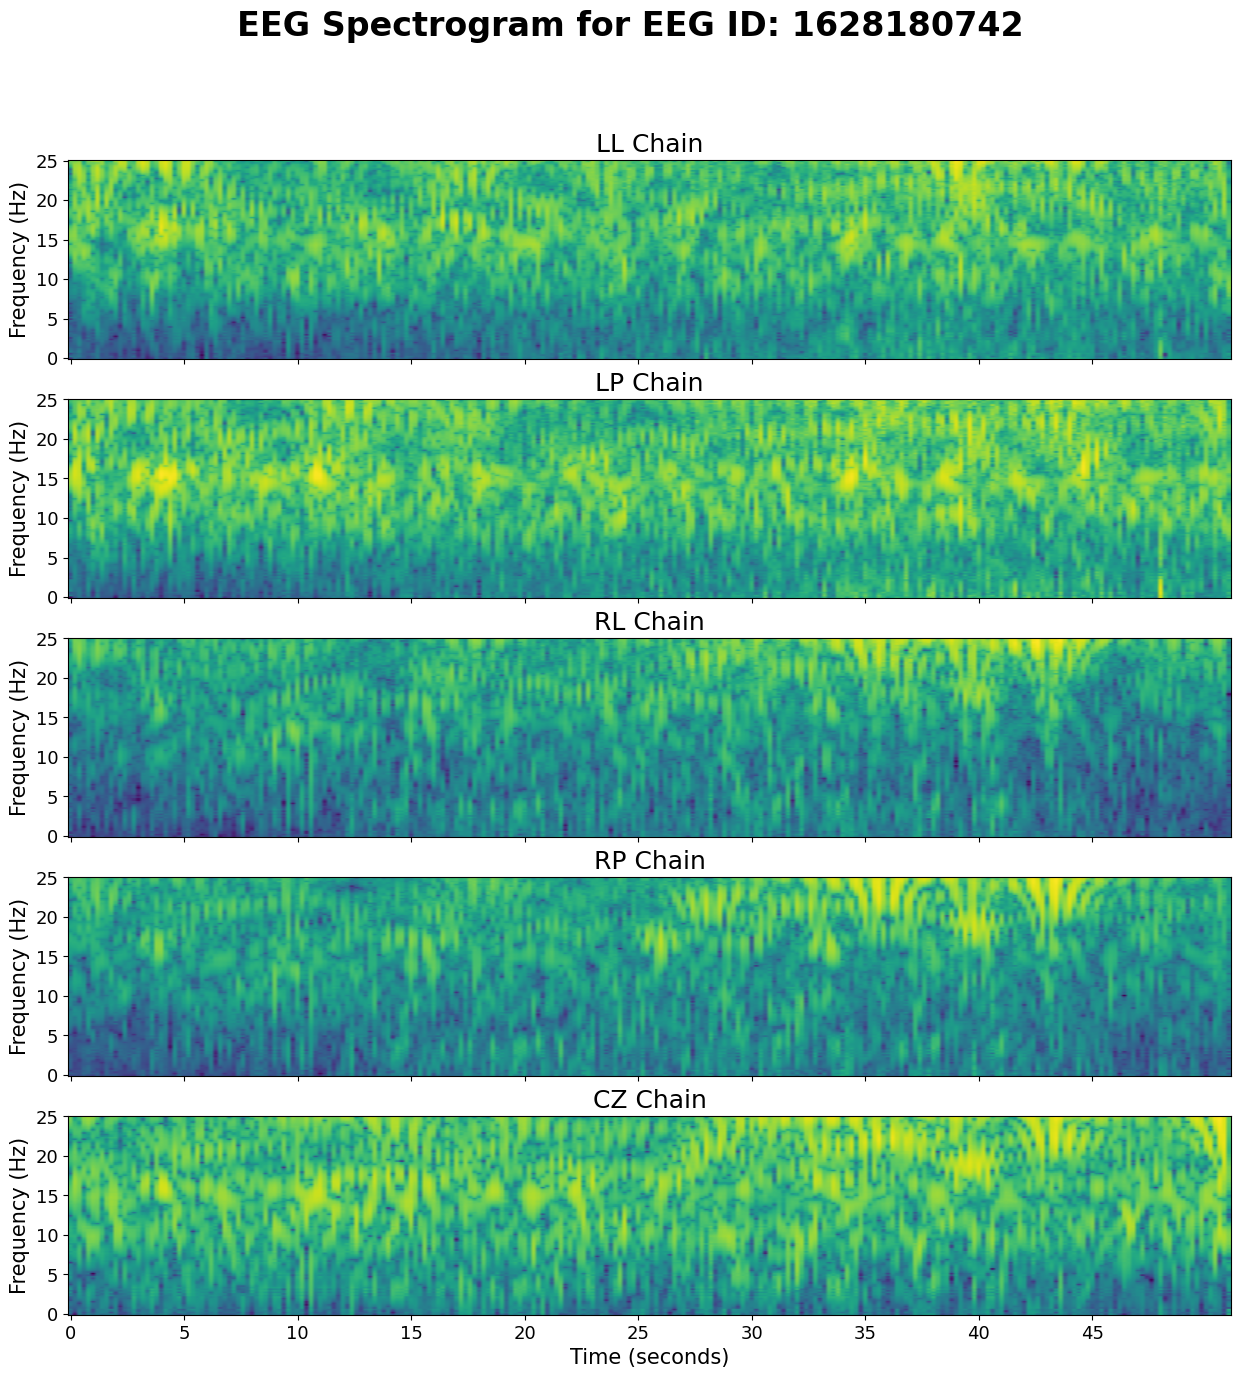

In [42]:
# visualize the EEG spectrogram
chain_names = ["LL", "LP", "RL", "RP", "CZ"]
fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = eeg_spectrogram_parquet[:, :, i]
    print(f"min: {spectrogram_data.min()}, max: {spectrogram_data.max()}")
    axs[i].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# 256 time steps for 50 seconds
axs[-1].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1] - 25, 25), labels=np.arange(0, spectrogram_data.shape[1] * (50 / spectrogram_data.shape[1]), 5).astype(int))
axs[-1].set_xlabel("Time (seconds)")

fig.suptitle(f"EEG Spectrogram for EEG ID: {eeg_id}", fontsize=24, fontweight='bold');